# physics760 - Problem Set 6

### Team:
- Sumin Alff-Kim : 3282322
- Lennart Voorgang: 3124372

### Code
- [Repository](https://github.com/lennartvrg/ComputationalPhysics)
- [Subdirectory for this assignment](https://github.com/lennartvrg/ComputationalPhysics/tree/main/5%20-%20The%20Ising%20Model%20in%202D)
- CommitID: **8d41270de0744873c66374e5baa6287e0870f302**

### Dependencies
- CMake 3.25+
- Thread building-blocks library. **ubuntu**: `sudo apt-get install libtbb-dev`. **macOS**: `brew install tbb`.
- `c++23` comptabile compiler **macOS**: As the Apple version of clang does not support parallel algorithms, one must install `gcc` via homebrew: `brew install gcc`.

### Run the `c++` code
- `mkdir build && cd build`
- `cmake .. && make ising_2d -j 4 && cp main ../6\ -\ Critical\ Slowing\ Down/`
- `cd ../6\ -\ Critical\ Slowing\ Down/ && ./ising_2d_critical_slowing_down`
- You should now have an output directory with several `CSV` files within it

### Run the `python` code
- Create the environment with `python3 -m venv .venv`
- To active the environment run `source .venv/bin/active` (Linux)
- To Install the required dependencies run `pip install -r requirements.txt`
- Run `jupyter notebook`

In [1]:
# Standard imports for computational physics
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter', 'notebook'])
plt.rcParams["figure.figsize"] = (12, 8)

# Critical Slowing Down

In [2]:
LATTICE_LENGTHS = np.array([4, 8, 12])

## Spontaneous Magnetization

<font color='blue'> **Q. Do an MCMC simulation with $N = 4$ for $J \in \{0.1, 0.2, J_c, 0.7, 0.8\}$. Pick a starting configuration that is checkerboarded with $+1$s and $−1$s, so that the starting mis close to $0$. Make a histogram that shows the respective frequency of $|m|$.**</font>

<font color='blue'> **Q. Do it again for $N = 8$ and $N = 12$.**</font>

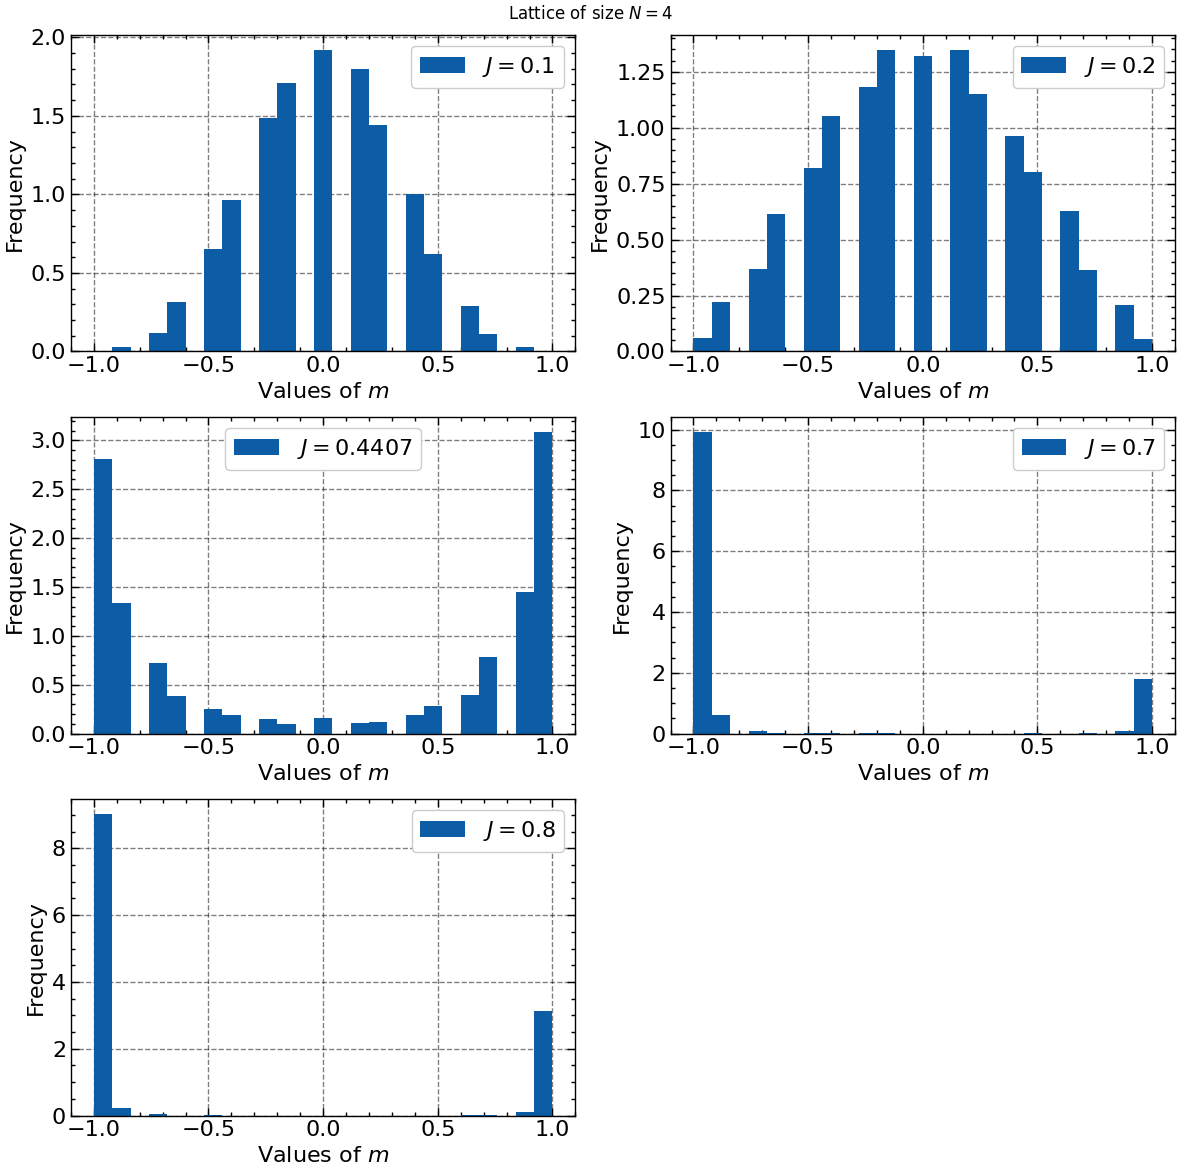

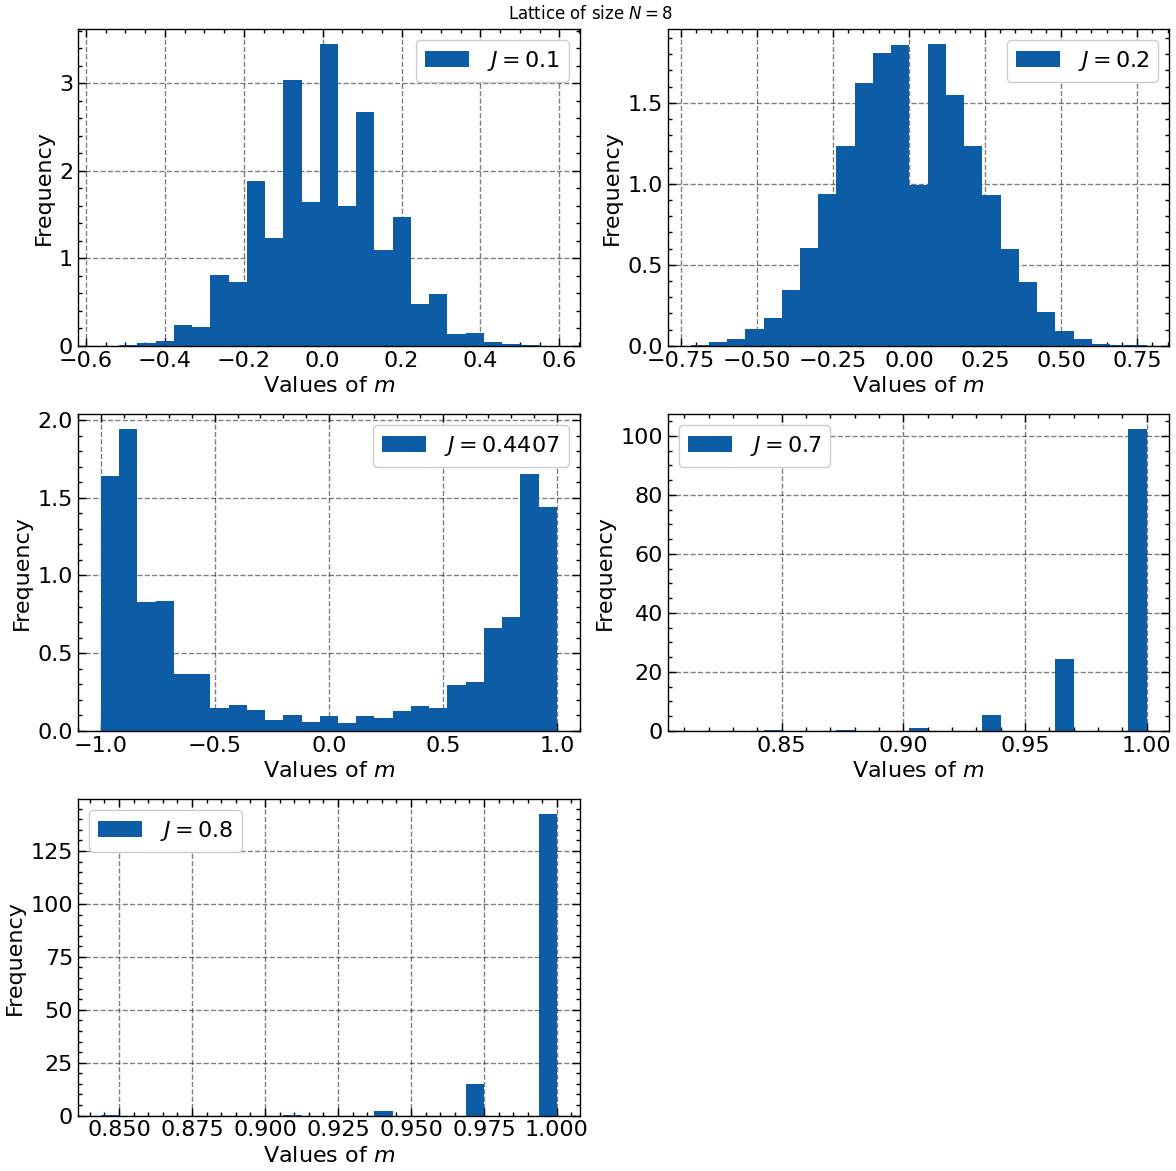

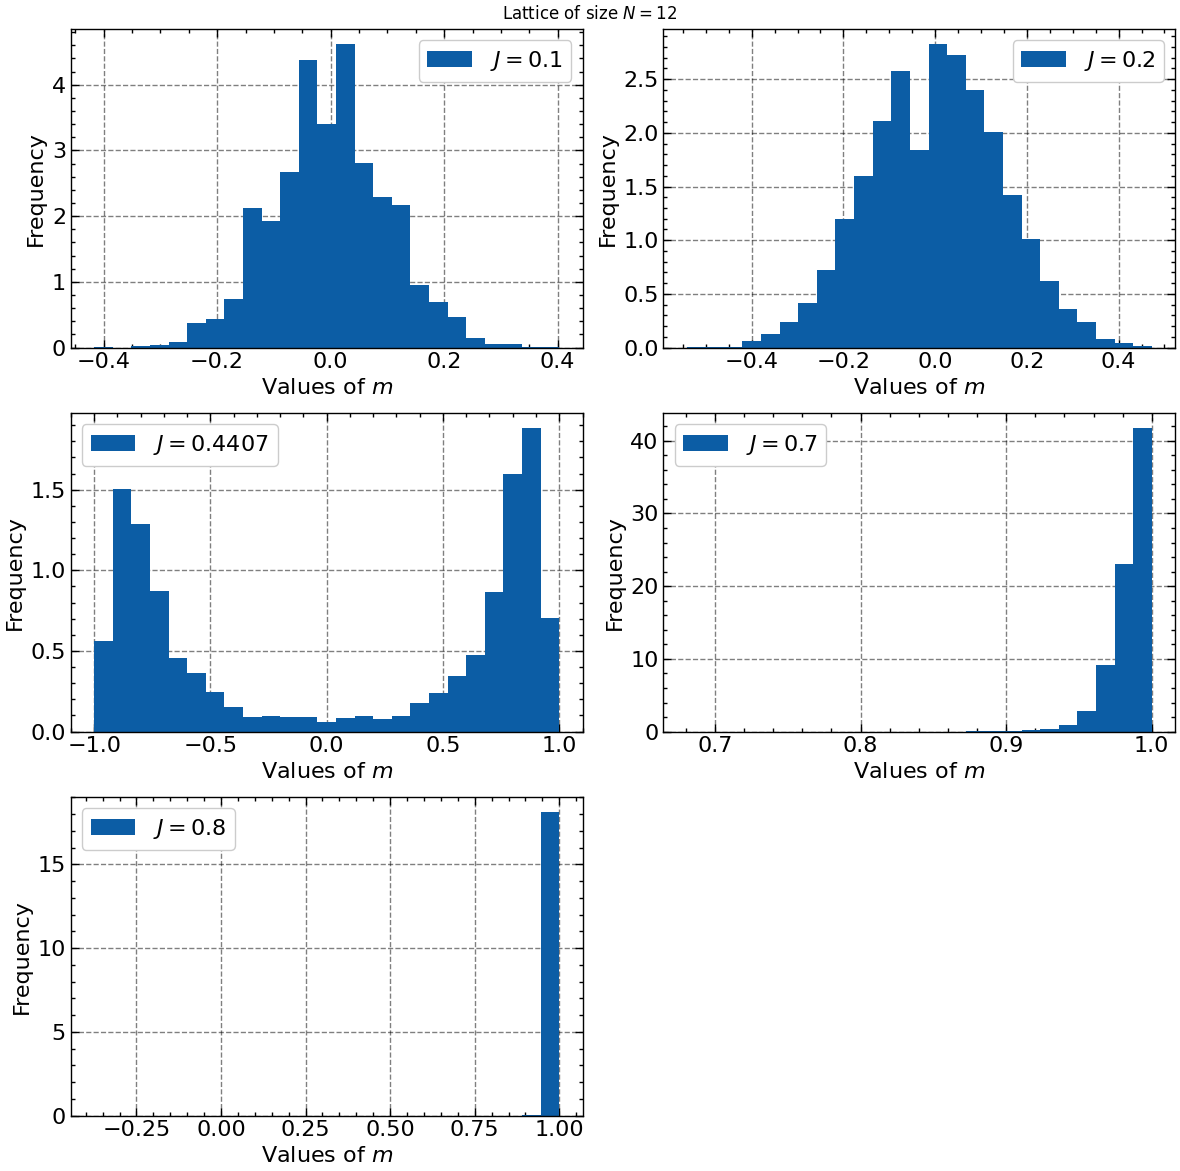

In [3]:
for length in LATTICE_LENGTHS:
    fig, ax = plt.subplots(3, 2, figsize=(12, 12))
    data = pd.read_csv(f'output/6_1_SpontaneousMagnetization_{length}.csv')

    for idx, (name, group) in enumerate(data.groupby('j')):
        ax[idx // 2, idx % 2].hist(group['magnetization'], bins=25, density=True, label=f'$J={name}$')
        ax[idx // 2, idx % 2].set_xlabel('Values of $m$')
        ax[idx // 2, idx % 2].set_ylabel('Frequency')
        ax[idx // 2, idx % 2].legend()

    fig.suptitle(f'Lattice of size $N = {length}$')
    fig.delaxes(ax[2, 1])
    fig.tight_layout()


<font color='blue'> **Q. Using the already-generated ensembles, overlay the histograms for the different N at fixed $J$ (one histogram per $J$).**</font>

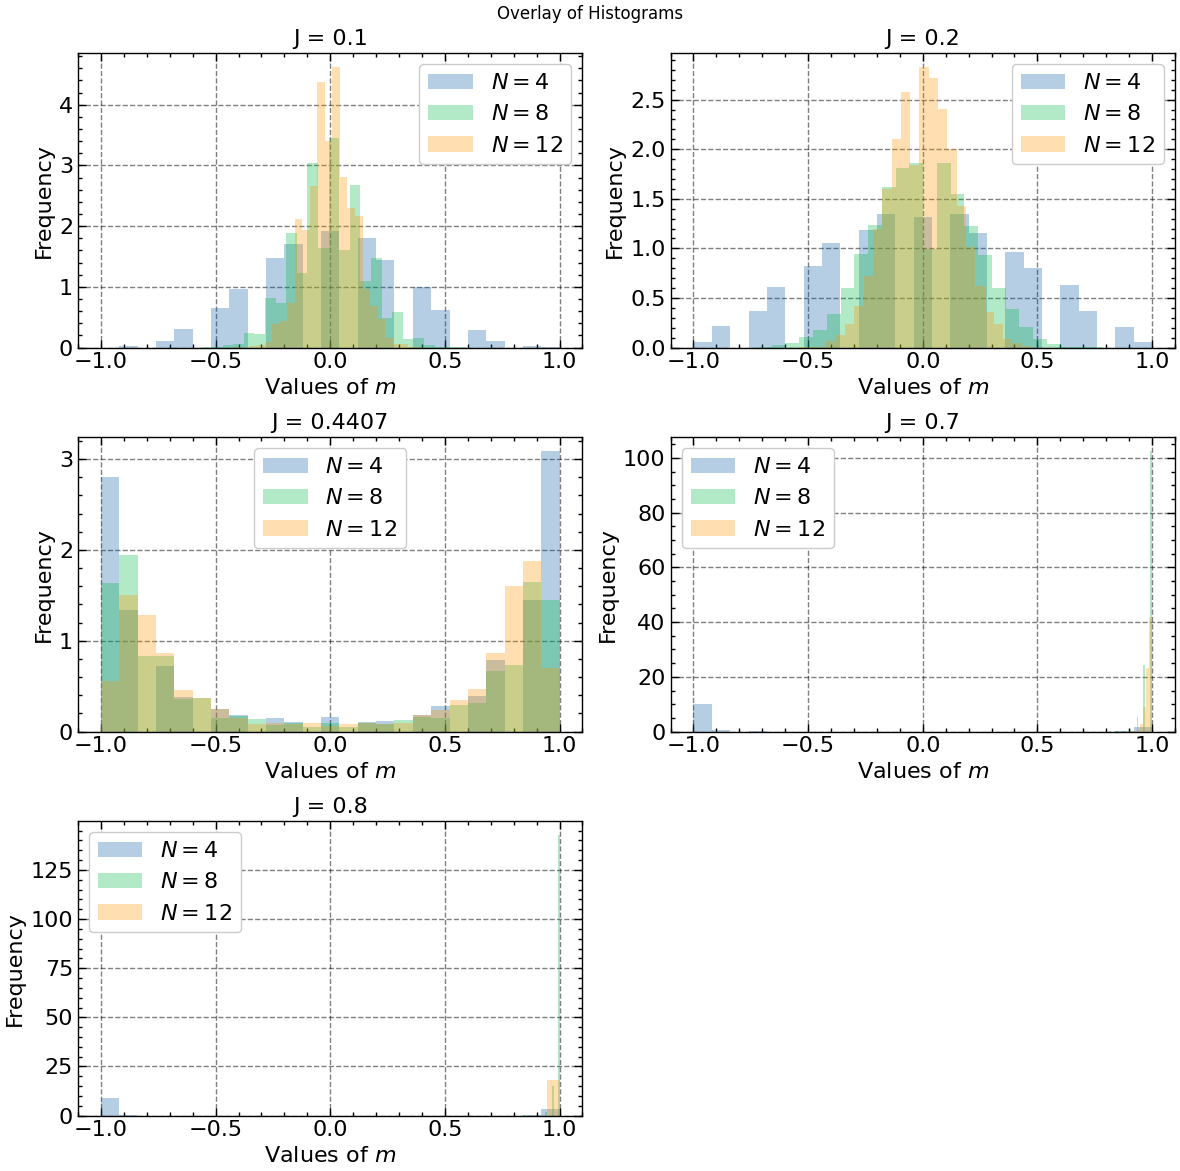

In [4]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

for length in LATTICE_LENGTHS:
    data = pd.read_csv(f'output/6_1_SpontaneousMagnetization_{length}.csv')

    for idx, (name, group) in enumerate(data.groupby('j')):
        ax[idx // 2, idx % 2].hist(group['magnetization'], bins=25, alpha=0.3, density=True, label=f'$N={length}$')
        ax[idx // 2, idx % 2].set_title(f'J = {name}')
        ax[idx // 2, idx % 2].set_xlabel('Values of $m$')
        ax[idx // 2, idx % 2].set_ylabel('Frequency')
        ax[idx // 2, idx % 2].legend()

fig.suptitle(f'Overlay of Histograms')
fig.delaxes(ax[2, 1])
fig.tight_layout()

<font color='blue'> **Q. Write a few sentences explaining the different tendencies as $N$ grows. Can you see evidence for the thermodynamic limit? Of spontaneous magnetization?**</font>

For small $J$ the deviation from $|m|=0$ gets smaller while for bigger $J$ the time spent at the limit $|m|=1$ gets bigger. For the broken phase $J=J_c$ all lattice sizes remain roughly the same except for the very extreme $|m|$ values. With increasing lattice size the bins for $|m|$ close to $1$ go down.

## Scanning $J$

In [5]:
def normalized_autocorrelation_function(data: pd.Series):
    series = data - data.mean()
    fft = np.fft.fft(series, n=2*len(series))

    correlation = np.fft.ifft(fft * np.conjugate(fft))[:len(series)].real
    return correlation / correlation[0]

def calculate_tau(gammas: pd.Series):
    return 0.5 + gammas[1:np.where(gammas <= 0)[0][0]].sum()

def thermalizing(data: pd.Series, tau: float):
    return data[3 * int(np.ceil(tau)):]

def blocking(data: pd.Series, tau: float):
    stride = int(np.ceil(tau));
    remainder = len(data) % stride
    
    return data[remainder:].reshape(-1, stride).mean(axis=-1)

def bootstrap_sampling(block: np.array, num_bootstrap_resamples = 100) -> Tuple[float, float]:
    draws = np.random.choice(block, size=(num_bootstrap_resamples, len(block))).mean(axis=1)
    return draws.mean(), draws.std()

<font color='blue'> **Q. Plot $|m|$ with error bars indicating uncertainty as a function of $J^{-1}$ (which is like $T$) over the exactly-known result.**</font>

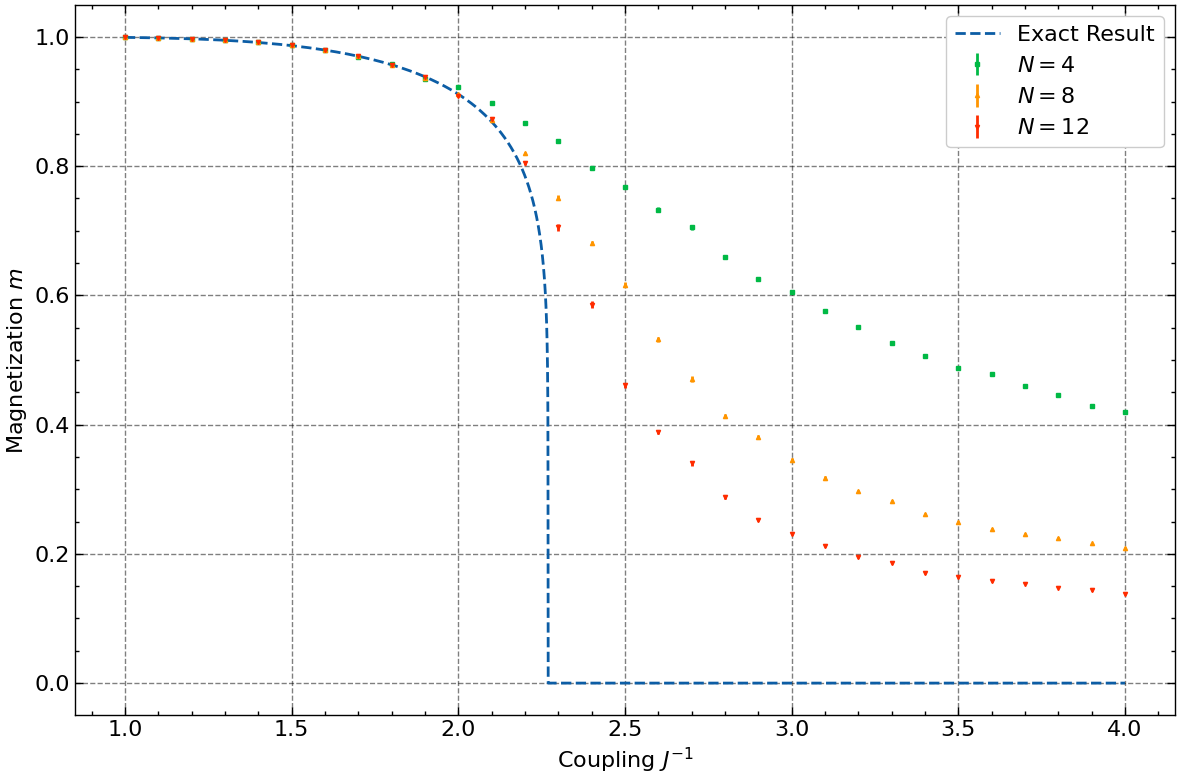

In [6]:
data = pd.read_csv('output/exact_results.csv')

fig, ax = plt.subplots()
ax.plot(1.0 / data['j'], data['magnetization'], '--', label='Exact Result')

for length in LATTICE_LENGTHS:
    data = pd.read_csv(f'output/6_2_ScanningJ_{length}.csv').groupby('j')

    x_values = []
    y_values = []
    y_uncertainty = []

    for name, group in data:
        x_values.append(1.0 / name)
        values = np.abs(group['magnetization'].to_numpy())

        tau = calculate_tau(normalized_autocorrelation_function(values))
        blocks = blocking(thermalizing(values, tau), tau)
        mean, std = bootstrap_sampling(blocks)

        y_values.append(mean)
        y_uncertainty.append(std)


    ax.errorbar(x_values, y_values, yerr=y_uncertainty, label=f'$N = {length}$');

ax.set_xlabel('Coupling $J^{-1}$')
ax.set_ylabel('Magnetization $m$')

ax.legend()
fig.tight_layout()

<font color='blue'> **Q. Plot $\epsilon / J$ with uncertainties as a function of $J^{-1}$ over the exactly-known result (don’t miss the $1/J$!).**</font>

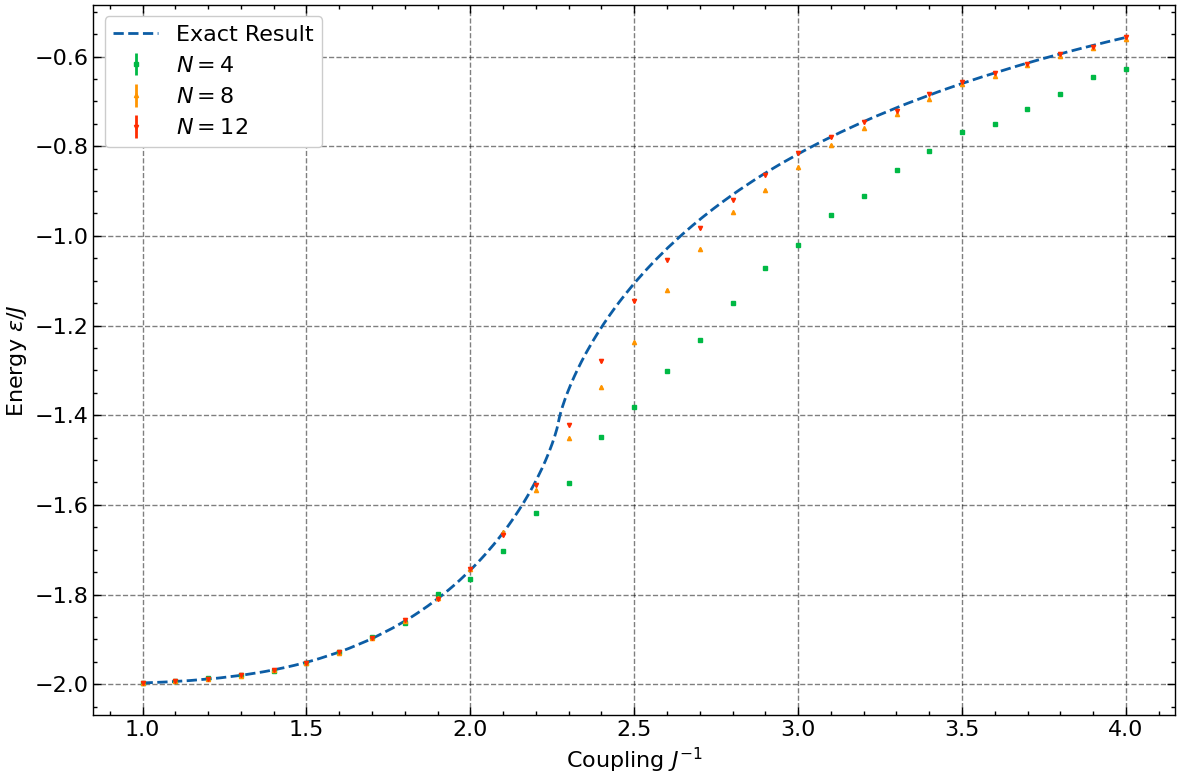

In [7]:
data = pd.read_csv('output/exact_results.csv')

fig, ax = plt.subplots()
ax.plot(1.0 / data['j'], data['energy'] / data['j'], '--', label='Exact Result')

for length in LATTICE_LENGTHS:
    data = pd.read_csv(f'output/6_2_ScanningJ_{length}.csv').groupby('j')

    x_values = []
    y_values = []
    y_uncertainty = []

    for name, group in data:
        x_values.append(1.0 / name)
        values = group['energy'].to_numpy()

        tau = calculate_tau(normalized_autocorrelation_function(values))
        blocks = blocking(thermalizing(values, tau), tau)
        mean, std = bootstrap_sampling(blocks)

        y_values.append(mean / name)
        y_uncertainty.append(std)


    ax.errorbar(x_values, y_values, yerr=y_uncertainty, label=f'$N = {length}$');

ax.set_xlabel('Coupling $J^{-1}$')
ax.set_ylabel('Energy $\\epsilon / J$')

ax.legend()
fig.tight_layout()

<font color='blue'> **Q. Even though we know we have severe tunneling problems in the broken phase, these (should) come out basically OK. Explain this observation.**</font>

We did the bootstrap resampling with $100$ samples to get the mean and uncertainty. The uncertainty is plotted but appears to be too small to see. When looking at the figures we see that with increasing lattice size we get ever closer to the thermodynamic limit.

<font color='red'> **I didn't come around to do the last two problems as I had the double experiment and the Proseminar presentation this week. Since we already got enough points I prioritized these things.**</font>